In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
'''
MSP is the fully connected network. It takes the embedding from vgg-16 + 
a screen context vector and learns to map onto reward or no reward.
'''

class MSP(nn.Module):
    def __init__(self):
        super(MSP, self).__init__()
        self.fc1 = nn.Linear(4196, 100)  # first hidden layer with 100 neurons
        self.fc2 = nn.Linear(100, 1)  # second (output) layer with 2 neurons

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = (self.fc2(x)) #torch.relu torch.sigmoid
        return x

class MyDataset(Dataset):
    def __init__(self, csv_path, labels):
        self.data = torch.tensor(pd.read_csv(csv_path, delimiter=',').values)
        self.labels = torch.tensor(labels)
        print(f"Data shape: {self.data.shape}, Labels shape: {self.labels.shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# display(enumerate(trainloader, 0))
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.uniform_(m.weight, a=-0.015,b=0.015)
#         # torch.nn.init.normal_(m.weight, mean=-1, std=1.0)
#         # m.bias.data.fill_(0.01)


In [6]:
labels = np.concatenate([np.repeat(1,4), np.repeat(0,16), np.repeat(1,4), np.repeat(0,8)]).reshape(32,1)

rewarded_labels = np.zeros(32)
rewarded_labels[2::4] = 1
rewarded_labels = np.concatenate([rewarded_labels, np.zeros(64), rewarded_labels]).reshape(128,1)

# create dataset and dataloader
dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/embeddings_vgg16/train_vgg-16_embeddings.csv', labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# create test dataset and dataloader
test_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/embeddings_vgg16/train_vgg-16_embeddings_generalization.csv', labels)
test_dataloader = DataLoader(test_dataset, batch_size=32)

# create probe dataset and dataloader
probe_labels = np.zeros(32)
probe_labels[2::4] = 1
probe_labels = np.concatenate([probe_labels, np.zeros(64), probe_labels]).reshape(128,1)
probe_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/embeddings_vgg16/train_vgg-16_embeddings_probe.csv', probe_labels)
probe_dataloader = DataLoader(probe_dataset, batch_size=128)

FileNotFoundError: ignored

In [ ]:
total = 32
num_epochs = 1000
num_runs = 10

train_performance = np.array([])
train_losses = np.array([])
test_performance = np.array([])
test_losses = np.array([])
probe_performance = np.array([])
probe_losses = np.array([])

train_performance_rewarded = np.array([])
train_performance_unrewarded = np.array([])

test_performance_rewarded = np.array([])
test_performance_unrewarded = np.array([])

probe_performance_rewarded = np.array([])
probe_performance_unrewarded = np.array([])

# train_performance_F1_C1 = np.array([])


for i in range(num_runs):

  model = MSP()

  # flat_list = [item for sublist in model.fc1.weight.detach().numpy() for item in sublist]
  # plt.hist(flat_list)
  # # print(net.ca1.weight)#.detach().numpy().squeeze().squeeze())
  # plt.show()

  # model.apply(init_weights)

  # flat_list = [item for sublist in model.fc1.weight.detach().numpy() for item in sublist]
  # plt.hist(flat_list)
  # # print(net.ca1.weight)#.detach().numpy().squeeze().squeeze())
  # plt.show()

  criterion = nn.MSELoss()
  optimizer = optim.SGD(model.parameters(), lr=0.0005) #0.0005

  with torch.no_grad():

    for batch, label in dataloader:
      data = batch.float() # cast input data to float
      target = label.float() # cast target labels to float
      output = model(data)
      loss = criterion(output, target)
      predicted = (output > 0.5).float()

      # display(output.T)

    train_performance = np.append(train_performance, (predicted == target).sum().item() * 100 / total)
    train_performance_rewarded = np.append(train_performance_rewarded, ((predicted == target)[slice(0, 4)].sum().item() * 100 / 8) +  ((predicted == target)[slice(20, 24)].sum().item() * 100 / 8))

    train_performance_unrewarded = np.append(train_performance_unrewarded, ((predicted == target)[slice(4, 20)].sum().item() * 100 / 24) +  ((predicted == target)[slice(24, 32)].sum().item() * 100 / 24))

    train_losses = np.append(train_losses, loss.item())



    for data, labels in test_dataloader:
      data = data.float()
      labels = labels.float()
      outputs = model(data)
      predicted = (outputs > 0.5).float()
    test_performance = np.append(test_performance, (predicted == labels).sum().item() * 100 / total)
    test_losses = np.append(test_losses, criterion(outputs,labels).item())
    
    test_performance_rewarded = np.append(test_performance_rewarded, ((predicted == labels)[slice(0, 4)].sum().item() * 100 / 8) +  ((predicted == labels)[slice(20, 24)].sum().item() * 100 / 8))
    test_performance_unrewarded = np.append(test_performance_unrewarded, ((predicted == labels)[slice(4, 20)].sum().item() * 100 / 24) +  ((predicted == labels)[slice(24, 32)].sum().item() * 100 / 24))
    
   
    for data, labels in probe_dataloader:
      data = data.float()
      labels = labels.float()
      outputs = model(data)
      predicted = (outputs > 0.5).float()
    probe_performance = np.append(probe_performance, (predicted == labels).sum().item() * 100 / 128)
    probe_losses = np.append(probe_losses, criterion(outputs,labels).item())
    
    # display(((predicted == labels)[96:][2::4]))
    probe_performance_rewarded = np.append(probe_performance_rewarded, ((predicted == labels)[:32][2::4].sum().item() * 100 / 16) + 
                                           ((predicted == labels)[96:][2::4].sum().item() * 100 / 16))
    probe_performance_unrewarded = np.append(probe_performance_unrewarded, (predicted == labels)[rewarded_labels == False].sum().item() * 100 / 112)


  for epoch in range(num_epochs):
      for batch, label in dataloader:
        optimizer.zero_grad()
        data = batch.float() # cast input data to float
        target = label.float() # cast target labels to float
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        predicted = (output > 0.5).float()
        # display(predicted[0:4], target[0:4])
        # display(predicted[0:4])
        # display(target[0:4])
        
        # display((predicted==target)[0:4].sum() * 100 /4)
        train_performance = np.append(train_performance, (predicted == target).sum().item() * 100 / total)
        train_performance_rewarded = np.append(train_performance_rewarded, ((predicted == target)[slice(0, 4)].sum().item() * 100 / 8) +  ((predicted == target)[slice(20, 24)].sum().item() * 100 / 8))
        train_performance_unrewarded = np.append(train_performance_unrewarded, ((predicted == target)[slice(4, 20)].sum().item() * 100 / 24) +  ((predicted == target)[slice(24, 32)].sum().item() * 100 / 24))

        train_losses = np.append(train_losses, loss.item())

      with torch.no_grad():
        for data, labels in test_dataloader:
          data = data.float()
          labels = labels.float()
          outputs = model(data)
          predicted = (outputs > 0.5).float()
        test_performance = np.append(test_performance, (predicted == labels).sum().item() * 100 / total)
        test_losses = np.append(test_losses, criterion(outputs,labels).item())
        test_performance_rewarded = np.append(test_performance_rewarded, ((predicted == labels)[slice(0, 4)].sum().item() * 100 / 8) +  ((predicted == labels)[slice(20, 24)].sum().item() * 100 / 8))
        test_performance_unrewarded = np.append(test_performance_unrewarded, ((predicted == labels)[slice(4, 20)].sum().item() * 100 / 24) +  ((predicted == labels)[slice(24, 32)].sum().item() * 100 / 24))


        for data, labels in probe_dataloader:
          data = data.float()
          labels = labels.float()
          outputs = model(data)
          predicted = (outputs > 0.5).float()
        probe_performance = np.append(probe_performance, (predicted == labels).sum().item() * 100 / 128)
        probe_losses = np.append(probe_losses, criterion(outputs,labels).item())

        probe_performance_rewarded = np.append(probe_performance_rewarded, ((predicted == labels)[:32][2::4].sum().item() * 100 / 16) + 
                                               ((predicted == labels)[96:][2::4].sum().item() * 100 / 16))
        probe_performance_unrewarded = np.append(probe_performance_unrewarded, (predicted == labels)[rewarded_labels == False].sum().item() * 100 / 112)

  if (i+1)%(num_runs/10) == 0:
    display(str((i+1)/num_runs*100) + "% done")

In [ ]:
train_performance_mean = (train_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
train_performance_sem = train_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
train_losses_mean = (train_losses.reshape(-1, num_epochs+1)).mean(axis = 0)
train_losses_sem = train_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

train_performance_rewarded_mean = (train_performance_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
train_performance_rewarded_sem = (train_performance_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

train_performance_unrewarded_mean = (train_performance_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
train_performance_unrewarded_sem = (train_performance_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

test_performance_mean = (test_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
test_performance_sem = test_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
test_losses_mean = (test_losses.reshape(-1, num_epochs+1)).mean(axis = 0)
test_losses_sem = test_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

test_performance_rewarded_mean = (test_performance_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
test_performance_rewarded_sem = (test_performance_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

test_performance_unrewarded_mean = (test_performance_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
test_performance_unrewarded_sem = (test_performance_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_performance_mean = (probe_performance.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_performance_sem = probe_performance.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)
probe_losses_mean = (probe_losses.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_losses_sem = probe_losses.reshape(-1, num_epochs+1).std(axis = 0) / np.sqrt(num_runs)

probe_performance_rewarded_mean = (probe_performance_rewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_performance_rewarded_sem = (probe_performance_rewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)

probe_performance_unrewarded_mean = (probe_performance_unrewarded.reshape(-1, num_epochs+1)).mean(axis = 0)
probe_performance_unrewarded_sem = (probe_performance_unrewarded.reshape(-1, num_epochs+1)).std(axis = 0) / np.sqrt(num_runs)


fig, ax = plt.subplots(1, 2, figsize=(15,5), facecolor='w', edgecolor='k', dpi = 100)
ax[0].plot(train_losses_mean)
ax[0].fill_between(range(num_epochs+1), train_losses_mean-train_losses_sem, train_losses_mean+train_losses_sem, alpha = 0.5)
ax[0].plot(test_losses_mean)
ax[0].fill_between(range(num_epochs+1), test_losses_mean-test_losses_sem, test_losses_mean+test_losses_sem, alpha = 0.5)
ax[0].plot(probe_losses_mean)
ax[0].fill_between(range(num_epochs+1), probe_losses_mean-probe_losses_sem, probe_losses_mean+probe_losses_sem, alpha = 0.5)
ax[0].axhline(0, color = 'k')
ax[0].set_title('Loss')
ax[0].legend(['45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
              '-15-degree set (generalization) mean', '-15-degree set (generalization)  SEM',
              'Probe set mean', 'Probe set SEM'],)
# ax[0].set_xticks(np.arange(0, 100.1, 10))
ax[0].grid()


ax[1].plot(train_performance_mean)
ax[1].fill_between(range(num_epochs+1), train_performance_mean-train_performance_sem, train_performance_mean+train_performance_sem, alpha = 0.5)
ax[1].plot(test_performance_mean)
ax[1].fill_between(range(num_epochs+1), test_performance_mean-test_performance_sem, test_performance_mean+test_performance_sem, alpha = 0.5)
ax[1].plot(probe_performance_mean)
ax[1].fill_between(range(num_epochs+1), probe_performance_mean-probe_performance_sem, probe_performance_mean+probe_performance_sem, alpha = 0.5)
ax[1].axhline(50, color = 'lightgray', ls = '--', label = 'chance')
# ax[1].axhline(75, color = 'darkgray', ls = '--', label = 'chance')
# ax[1].fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')
ax[1].axhline(100, color = 'k')
ax[1].set_title('Performance')
ax[1].legend(['45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
              '-15-degree set (generalization) mean', '-15-degree set (generalization)  SEM', 
              'Probe set mean', 'Probe set SEM','chance performance',], loc='lower right')
# ax[1].set_xticks(np.arange(0, 100.1, 10))
ax[1].set_yticks(np.arange(0, 100.1, 10))
ax[1].grid()

fig.tight_layout()

NameError: ignored

Text(0, 0.5, 'Performance')

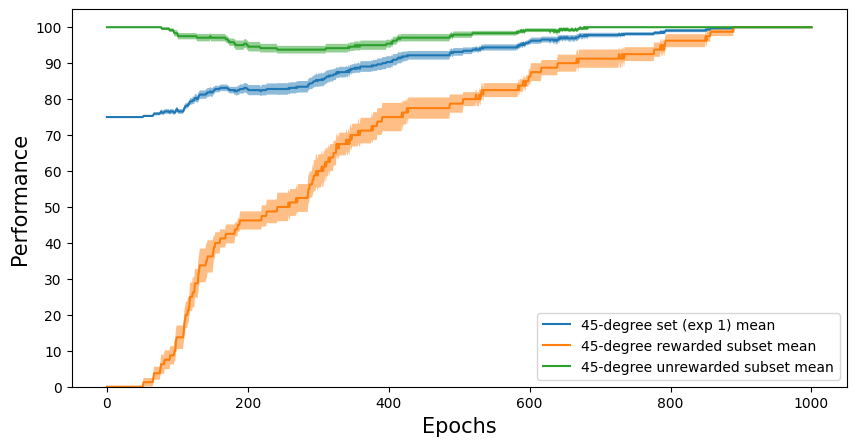

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_performance_mean)
ax.plot(train_performance_rewarded_mean)
ax.plot(train_performance_unrewarded_mean)

ax.fill_between(range(num_epochs+1), train_performance_mean-train_performance_sem, train_performance_mean+train_performance_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), train_performance_rewarded_mean-train_performance_rewarded_sem, train_performance_rewarded_mean+train_performance_rewarded_sem, alpha = 0.5)
z
ax.fill_between(range(num_epochs+1), train_performance_unrewarded_mean-train_performance_unrewarded_sem, train_performance_unrewarded_mean+train_performance_unrewarded_sem, alpha = 0.5)

# ax.plot(test_performance_mean)
# ax.fill_between(range(num_epochs+1), test_performance_mean-test_performance_sem, test_performance_mean+test_performance_sem, alpha = 0.5)

# ax.plot(test_performance_rewarded_mean)
# ax.fill_between(range(num_epochs+1), test_performance_rewarded_mean-test_performance_rewarded_sem, test_performance_rewarded_mean+test_performance_rewarded_sem, alpha = 0.5)

# ax.plot(test_performance_unrewarded_mean)
# ax.fill_between(range(num_epochs+1), test_performance_unrewarded_mean-test_performance_unrewarded_sem, test_performance_unrewarded_mean+test_performance_unrewarded_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1) mean', '45-degree rewarded subset mean', '45-degree unrewarded subset mean'], loc='lower right') #'45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
           #'45-degree rewarded subset mean', '45-degree rewarded subset SEM',

ax.set_yticks(np.arange(0, 100.1, 10))
ax.set_ylim(0,105)
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel("Performance", fontsize = 15)
# ax.grid()

# display(test_performance_unrewarded.shape)

Text(0, 0.5, 'Performance')

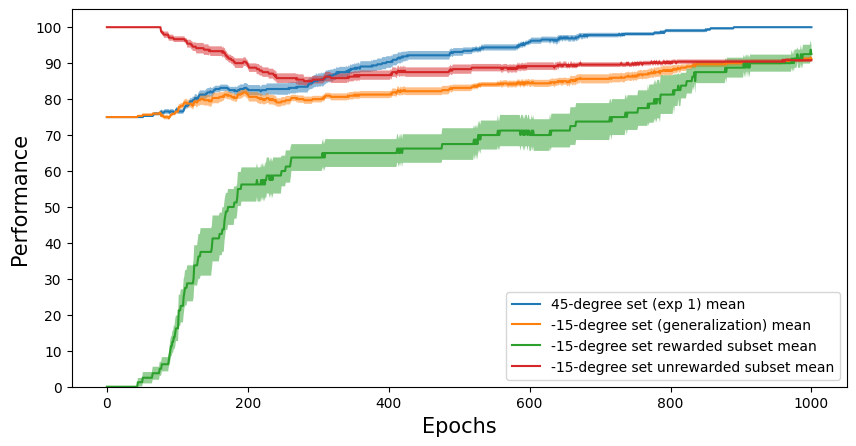

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_performance_mean)
ax.plot(test_performance_mean)
ax.plot(test_performance_rewarded_mean)
ax.plot(test_performance_unrewarded_mean)

ax.fill_between(range(num_epochs+1), train_performance_mean-train_performance_sem, train_performance_mean+train_performance_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_performance_mean-test_performance_sem, test_performance_mean+test_performance_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_performance_rewarded_mean-test_performance_rewarded_sem, test_performance_rewarded_mean+test_performance_rewarded_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), test_performance_unrewarded_mean-test_performance_unrewarded_sem, test_performance_unrewarded_mean+test_performance_unrewarded_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1) mean', 
           '-15-degree set (generalization) mean', 
           '-15-degree set rewarded subset mean', 
           '-15-degree set unrewarded subset mean',
            ], loc='lower right') #'45-degree set (exp 1) mean', '45-degree set (exp 1) SEM', 
           #'45-degree rewarded subset mean', '45-degree rewarded subset SEM',

ax.set_yticks(np.arange(0, 100.1, 10))
ax.set_ylim(0,105)
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel("Performance", fontsize = 15)

Text(0, 0.5, 'Performance')

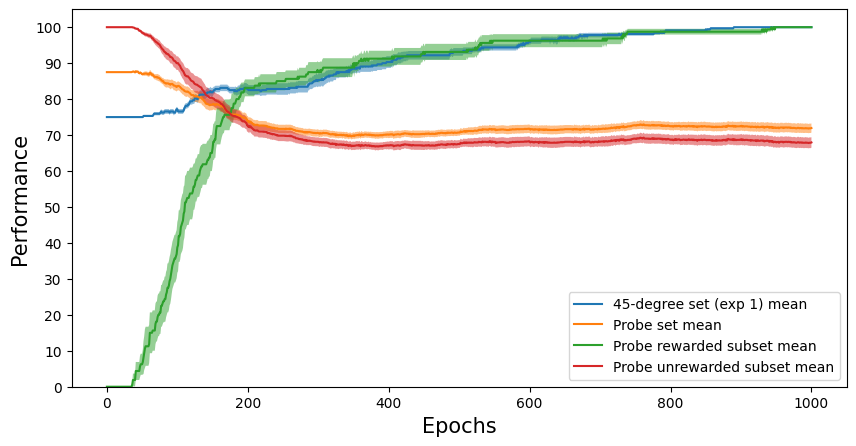

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), facecolor='w', edgecolor='k', dpi = 100)

ax.plot(train_performance_mean)
ax.plot(probe_performance_mean)
ax.plot(probe_performance_rewarded_mean)
ax.plot(probe_performance_unrewarded_mean)

ax.fill_between(range(num_epochs+1), train_performance_mean-train_performance_sem, train_performance_mean+train_performance_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_performance_mean-probe_performance_sem, probe_performance_mean+probe_performance_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_performance_rewarded_mean-probe_performance_rewarded_sem, probe_performance_rewarded_mean+probe_performance_rewarded_sem, alpha = 0.5)
ax.fill_between(range(num_epochs+1), probe_performance_unrewarded_mean-probe_performance_unrewarded_sem, probe_performance_unrewarded_mean+probe_performance_unrewarded_sem, alpha = 0.5)

# ax.axhline(50, color = 'darkgray', ls = '--', label = 'chance')
# ax.fill_betweenx(np.linspace(-10, 110, 100), 15, 60, alpha=0.2, color='gray')

ax.legend(['45-degree set (exp 1) mean', 
           'Probe set mean',
           'Probe rewarded subset mean',
           'Probe unrewarded subset mean',
            ], loc='lower right')

ax.set_yticks(np.arange(0, 100.1, 10))
ax.set_ylim(0,105)
# ax.grid()
ax.set_xlabel("Epochs", fontsize = 15)
ax.set_ylabel("Performance", fontsize = 15)



In [ ]:
# ## TSP

# class TSP(nn.Module):
#   def __init__(self, input_size, hidden_size, output_size, sparsity):
#       super(TSP, self).__init__()
#       self.input_size = input_size
#       self.hidden_size = hidden_size
#       self.output_size = output_size
#       self.sparsity = sparsity


#       # initialize weight matrix with zeros
#       self.w1 = nn.Parameter(torch.zeros(hidden_size, input_size))
#       self.w2 = nn.Parameter(torch.zeros(output_size, hidden_size))

#       # create a mask with the same shape as the weight matrix
#       self.mask1 = torch.ones(hidden_size, input_size)
#       self.mask2 = torch.ones(output_size, hidden_size)

#       # set random elements of the mask to zero according to the sparsity
#       num_zeros1 = int(sparsity * hidden_size * input_size)
#       num_zeros2 = int(sparsity * output_size * hidden_size)
#       indices1 = torch.randperm(hidden_size * input_size)[:num_zeros1]
#       indices2 = torch.randperm(output_size * hidden_size)[:num_zeros2]
#       self.mask1.view(-1)[indices1] = 0
#       self.mask2.view(-1)[indices2] = 0

#       # register the mask as a buffer so it is not updated during training
#       self.register_buffer('mask1', self.mask1)
#       self.register_buffer('mask2', self.mask2)

#       self.relu = nn.ReLU()
#       self.sigmoid = nn.Sigmoid()

#   def forward(self, x):
#       x = torch.mm(x, self.w1 * self.mask1.T)
#       x = self.relu(x)
#       x = torch.mm(x, self.w2 * self.mask2.T)
#       x = self.sigmoid(x)
#       return x


# class SparseLinear(nn.Module):
#   def __init__(self, in_features, out_features, sparse_indices):
#     super(SparseLinear, self).__init__()
#     self.weight = nn.Parameter(data=torch.sparse.FloatTensor(sparse_indices, torch.randn(sparse_indices.shape[1]), [in_features, out_features]), requires_grad=True)
#     self.bias = nn.Parameter(data=torch.randn(out_features), requires_grad=True)



In [ ]:
# # create train and test datasets and dataloaders
# labels = np.concatenate([np.repeat(1,4), np.repeat(0,16), np.repeat(1,4), np.repeat(0,8), 
#                          np.repeat(0,4), np.repeat(1,16), np.repeat(0,4), np.repeat(1,8)])

# tsp_train_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/train_vgg-16_embeddings.csv', labels)
# tsp_train_dataloader = DataLoader(tsp_train_dataset, batch_size=32, shuffle=True)
# tsp_test_dataset = MyDataset('/content/drive/MyDrive/rhesus_category_learning_model/train_vgg-16_embeddings_generalization.csv', labels)
# tsp_test_dataloader = DataLoader(tsp_test_dataset, batch_size=32)

# # set up the model, loss function, and optimizer
# model = TSP(4196, 100, 2, 0.9)
# criterion = nn.MSELoss() # nn.BCEWithLogitsLoss() if we switch to one unit output (binary)
# optimizer = optim.SGD(model.parameters(), lr=0.01) # torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# # define sparse matrix
# indices = [[0, 1, 1, 2], [0, 1, 3, 4]]
# values = [1, 2, 3, 4]
# shape = [5, 3]
# sparse_matrix = torch.sparse_coo_tensor(indices, values, shape)

# sparse_matrix

In [ ]:
rewarded_labels = np.zeros(32)
rewarded_labels[2::4] = 1
rewarded_labels = np.concatenate([rewarded_labels, np.zeros(64), rewarded_labels])

[rewarded_labels == False]

[array([ True,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,
        False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,
      